In [1]:
from exprel.dataset.semeval_dataset import SemevalDataset
import exprel.utils
from dotenv import load_dotenv 
load_dotenv()

True

In [2]:
data = SemevalDataset("/home/kovacs/projects/exp-relation-extraction/data/semeval_train.txt")

2021-05-05 13:02:37 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

/home/kovacs/miniconda3/envs/rel/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2021-05-05 13:02:37 INFO: Use device: cpu
2021-05-05 13:02:37 INFO: Loading: tokenize
2021-05-05 13:02:37 INFO: Loading: pos
2021-05-05 13:02:38 INFO: Lo

In [3]:
data.load_graphs("pickle.dat")

In [4]:
df = data.to_dataframe()

In [5]:
df_entity_des = df[df.label == "Entity-Destination(e2,e1)"]
df = df.drop(df_entity_des.index, axis=0)

In [6]:
df.groupby("label").size()

label
Cause-Effect(e1,e2)           344
Cause-Effect(e2,e1)           659
Component-Whole(e1,e2)        470
Component-Whole(e2,e1)        471
Content-Container(e1,e2)      374
Content-Container(e2,e1)      166
Entity-Destination(e1,e2)     844
Entity-Origin(e1,e2)          568
Entity-Origin(e2,e1)          148
Instrument-Agency(e1,e2)       97
Instrument-Agency(e2,e1)      407
Member-Collection(e1,e2)       78
Member-Collection(e2,e1)      612
Message-Topic(e1,e2)          490
Message-Topic(e2,e1)          144
Other                        1410
Product-Producer(e1,e2)       323
Product-Producer(e2,e1)       394
dtype: int64

In [7]:
import pandas as pd

ids = pd.to_numeric(df.sen_id).tolist()
sentences = df.sentence.tolist()
labels = df.label_id.tolist()
postprocessed_graphs = df.graph.tolist()

In [8]:
from exprel.feature_extractor.extract import FeatureExtractor
from exprel.models.model import GraphModel

extractor = FeatureExtractor()
model = GraphModel()

In [9]:
from tqdm import tqdm

for ind, graph, label in tqdm(zip(ids, postprocessed_graphs, labels)):
    model.featurize_sen_graph(ind, graph, label, 3)

7999it [06:33, 20.34it/s]


In [10]:
model.vocab_size

387499

In [11]:
feature_graphs = model.get_feature_graphs()

In [12]:
model.select_n_best_from_each_class(400, feature_graphs)

In [13]:
X, Y = model.get_x_y(df.label.tolist())

In [14]:
from sklearn.model_selection import train_test_split as split

tr_data,tst_data,tr_labels,tst_labels = split(X,Y, test_size=0.2, random_state=1234)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0).fit(tr_data, tr_labels)
clf = OneVsRestClassifier(DecisionTreeClassifier(random_state=0, max_depth=4)).fit(tr_data, tr_labels)

In [201]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
keys = model.label_vocab.word_to_id.keys()
labels_to_result = {}
lr_pred = clf.predict(tr_data)
#prf = precision_recall_fscore_support(tst_labels, lr_pred, average=None)
print(classification_report(tr_labels, lr_pred, target_names=keys, output_dict=False))

                           precision    recall  f1-score   support

   Component-Whole(e2,e1)       0.69      0.25      0.37       384
                    Other       0.24      0.48      0.32      1127
 Instrument-Agency(e2,e1)       0.53      0.50      0.52       323
 Member-Collection(e1,e2)       0.65      0.17      0.28        63
      Cause-Effect(e2,e1)       0.97      0.43      0.59       533
Entity-Destination(e1,e2)       0.74      0.80      0.77       648
 Content-Container(e1,e2)       0.43      0.67      0.53       298
     Message-Topic(e1,e2)       0.69      0.07      0.13       391
  Product-Producer(e2,e1)       0.55      0.31      0.40       324
 Member-Collection(e2,e1)       0.41      0.88      0.56       496
     Entity-Origin(e1,e2)       0.64      0.63      0.63       474
      Cause-Effect(e1,e2)       0.87      0.62      0.73       271
   Component-Whole(e1,e2)       0.55      0.15      0.23       375
     Message-Topic(e2,e1)       0.81      0.14      0.23     

In [36]:
s

{'Component-Whole(e2,e1)': {'precision': 0.6906474820143885,
  'recall': 0.25,
  'f1-score': 0.367112810707457,
  'support': 384},
 'Other': {'precision': 0.23948649845064188,
  'recall': 0.4800354924578527,
  'f1-score': 0.3195510927347903,
  'support': 1127},
 'Instrument-Agency(e2,e1)': {'precision': 0.5326797385620915,
  'recall': 0.5046439628482973,
  'f1-score': 0.5182829888712243,
  'support': 323},
 'Member-Collection(e1,e2)': {'precision': 0.6470588235294118,
  'recall': 0.1746031746031746,
  'f1-score': 0.275,
  'support': 63},
 'Cause-Effect(e2,e1)': {'precision': 0.9743589743589743,
  'recall': 0.4277673545966229,
  'f1-score': 0.5945241199478488,
  'support': 533},
 'Entity-Destination(e1,e2)': {'precision': 0.7421203438395415,
  'recall': 0.7993827160493827,
  'f1-score': 0.7696879643387816,
  'support': 648},
 'Content-Container(e1,e2)': {'precision': 0.43412526997840173,
  'recall': 0.674496644295302,
  'f1-score': 0.5282522996057819,
  'support': 298},
 'Message-Topic(

In [18]:
clf.estimators_

[DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0),
 DecisionTreeClassifier(max_depth=6, random_state=0)]

In [223]:
from sklearn.tree import _tree
import numpy as np

def tree_to_code(tree):
    tree_ = tree.tree_
    feature_name = [
        feature_graph_strings[model.inverse_relabel[int(i)]] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            for path in recurse(tree_.children_left[node], depth + 1):
                yield [path[0], path[1] + [name], path[2]]
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            for path in recurse(tree_.children_right[node], depth + 1):
                yield [path[0] + [name], path[1], path[2]]
        else:
            yield [[], [], np.argmax(tree_.value[node])]
            print("{}return {}".format(indent, np.argmax(tree_.value[node])))

    return recurse(0, 1)

In [224]:
paths = list(tree_to_code(clf.estimators_[4]))

  if (u_54 / cause  :1 (u_4 / entity2)) <= 0.5:
    if (u_23 / by  :1 (u_54 / cause)) <= 0.5:
      if (u_2 / entity1  :0 (u_620 / trigger)) <= 0.5:
        if (u_54 / cause  :2 (u_2 / entity1)) <= 0.5:
          return 0
        else:  # if (u_54 / cause  :2 (u_2 / entity1)) > 0.5
          return 1
      else:  # if (u_2 / entity1  :0 (u_620 / trigger)) > 0.5
        if (u_2 / entity1  :0 (u_4 / entity2)) <= 0.5:
          return 1
        else:  # if (u_2 / entity1  :0 (u_4 / entity2)) > 0.5
          return 0
    else:  # if (u_23 / by  :1 (u_54 / cause)) > 0.5
      if (u_72 / contain  :2 (u_2 / entity1)) <= 0.5:
        if (u_7 / in  :1 (u_578 / work)) <= 0.5:
          return 1
        else:  # if (u_7 / in  :1 (u_578 / work)) > 0.5
          return 0
      else:  # if (u_72 / contain  :2 (u_2 / entity1)) > 0.5
        return 0
  else:  # if (u_54 / cause  :1 (u_4 / entity2)) > 0.5
    if (u_2 / entity1  :0 (u_54 / cause)) <= 0.5:
      if (u_54 / cause  :2 (u_2 / entity1)  :1 (

In [226]:
feats = [path for path in paths if path[2]]
print(paths)

[[[], ['(u_54 / cause  :2 (u_2 / entity1))', '(u_2 / entity1  :0 (u_620 / trigger))', '(u_23 / by  :1 (u_54 / cause))', '(u_54 / cause  :1 (u_4 / entity2))'], 0], [['(u_54 / cause  :2 (u_2 / entity1))'], ['(u_2 / entity1  :0 (u_620 / trigger))', '(u_23 / by  :1 (u_54 / cause))', '(u_54 / cause  :1 (u_4 / entity2))'], 1], [['(u_2 / entity1  :0 (u_620 / trigger))'], ['(u_2 / entity1  :0 (u_4 / entity2))', '(u_23 / by  :1 (u_54 / cause))', '(u_54 / cause  :1 (u_4 / entity2))'], 1], [['(u_2 / entity1  :0 (u_4 / entity2))', '(u_2 / entity1  :0 (u_620 / trigger))'], ['(u_23 / by  :1 (u_54 / cause))', '(u_54 / cause  :1 (u_4 / entity2))'], 0], [['(u_23 / by  :1 (u_54 / cause))'], ['(u_7 / in  :1 (u_578 / work))', '(u_72 / contain  :2 (u_2 / entity1))', '(u_54 / cause  :1 (u_4 / entity2))'], 1], [['(u_7 / in  :1 (u_578 / work))', '(u_23 / by  :1 (u_54 / cause))'], ['(u_72 / contain  :2 (u_2 / entity1))', '(u_54 / cause  :1 (u_4 / entity2))'], 0], [['(u_72 / contain  :2 (u_2 / entity1))', '(u_2

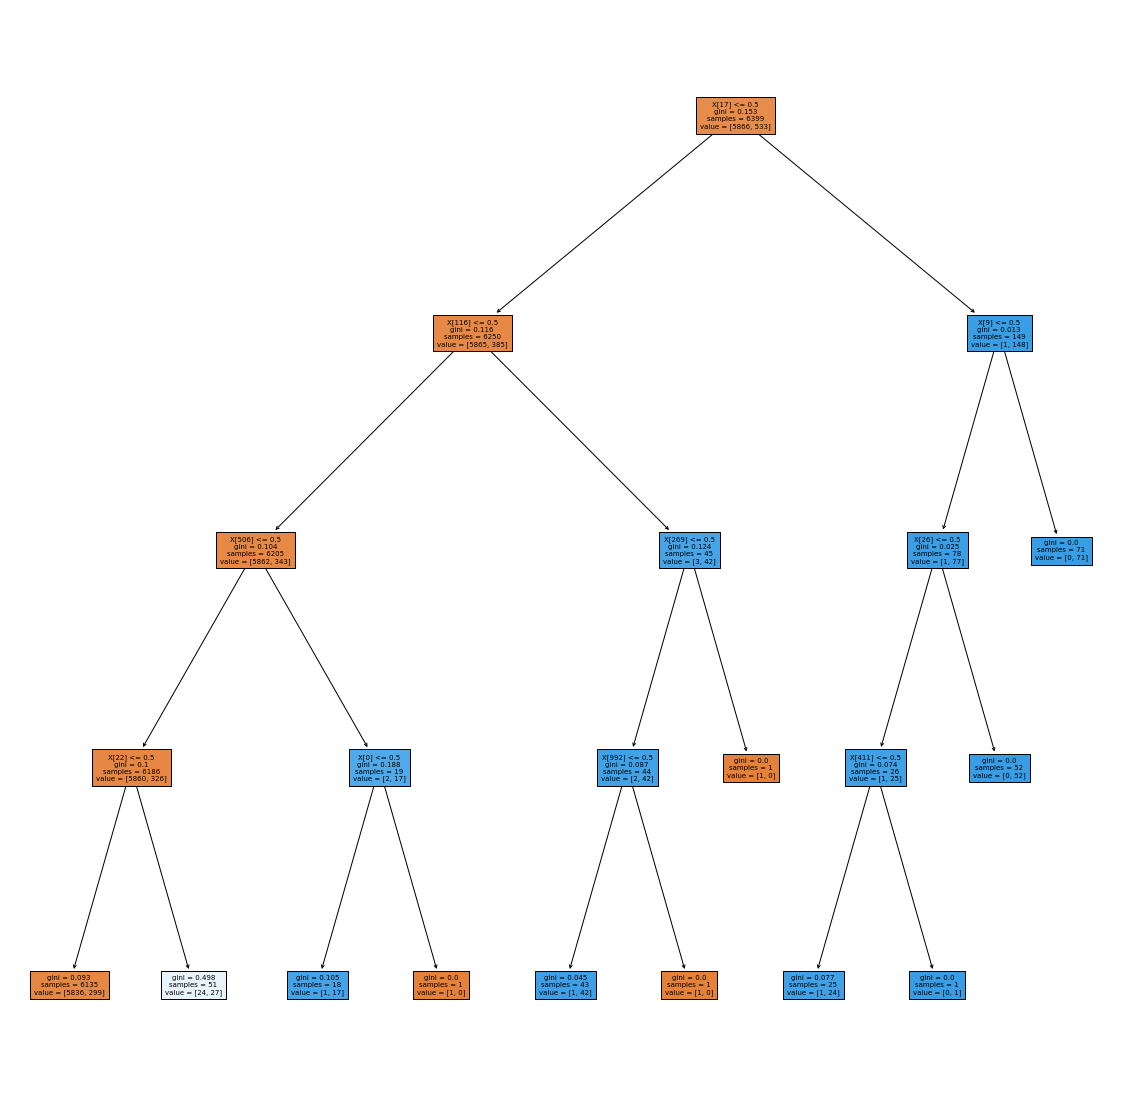

In [227]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

from sklearn.tree import plot_tree
t = plot_tree(clf.estimators_[4], filled=True, fontsize=7)


In [190]:
import eli5

In [191]:
weights_df = eli5.explain_weights_df(clf.estimators_[4])

In [192]:
weights_df

,feature,weight
0,x17,0.669851
1,x116,0.182642
2,x506,0.071214
3,x22,0.061967
4,x992,0.004944
...,...,...
1195,x799,0.000000
1196,x800,0.000000
1197,x801,0.000000
1198,x802,0.000000


In [23]:
feature_graph_strings = model.get_feature_graph_strings()

In [193]:
from collections import defaultdict
features = defaultdict(list)

for j, est in enumerate(clf.estimators_):
    paths = [i for i in list(tree_to_code(est)) if i[2]]
    for path in paths:
        features[list(keys)[j]].append((path[0], path[1], model.label_vocab.id_to_word[j]))

In [194]:
features

defaultdict(list,
            {'Component-Whole(e2,e1)': [(['(u_133 / include  :2 (u_4 / entity2))'],
               ['(u_10 / HAS  :1 (u_2 / entity1))',
                '(u_1158 / comprise  :1 (u_2 / entity1))',
                '(u_0 / have  :1 (u_2 / entity1)  :2 (u_4 / entity2))'],
               'Component-Whole(e2,e1)'),
              (['(u_1158 / comprise  :1 (u_2 / entity1))'],
               ['(u_4 / entity2  :0 (u_582 / several))',
                '(u_10 / HAS  :1 (u_11 / its))',
                '(u_0 / have  :1 (u_2 / entity1)  :2 (u_4 / entity2))'],
               'Component-Whole(e2,e1)'),
              (['(u_4 / entity2  :0 (u_582 / several))',
                '(u_1158 / comprise  :1 (u_2 / entity1))'],
               ['(u_10 / HAS  :1 (u_11 / its))',
                '(u_0 / have  :1 (u_2 / entity1)  :2 (u_4 / entity2))'],
               'Component-Whole(e2,e1)'),
              (['(u_0 / have  :1 (u_2 / entity1)  :2 (u_4 / entity2))'],
               ['(u_10 / HAS  :1 (u_1

In [215]:
from collections import defaultdict
features = defaultdict(list)

for target in weights_df.target.unique():
    targeted_df = weights_df[weights_df.target == target]
    most_important_weights = targeted_df.iloc[:5].feature.str.strip("x").tolist()
    for i in most_important_weights:
        if i != "<BIAS>":
            g_nx = feature_graphs[model.inverse_relabel[int(i)]]
            if len(g_nx.edges()):
                g = feature_graph_strings[model.inverse_relabel[int(i)]]
                features[list(keys)[int(target)]].append((g, [], model.label_vocab.id_to_word[int(target)]))

In [195]:
import json

with open("features.json", "w+") as f:
    json.dump(features, f)

In [31]:
train, val = split(df, test_size=0.2, random_state=1234) 

In [32]:
train.to_pickle("train_dataset")

In [214]:
def one_versus_rest(df, entity):
    mapper = {entity: 1}

    one_versus_rest_df = df.copy()
    one_versus_rest_df["one_versus_rest"] = [
        mapper[item] if item in mapper else 0 for item in df.label]

    return one_versus_rest_df

graphs = train.graph.tolist()
labels = one_versus_rest(train, "Cause-Effect(e2,e1)").one_versus_rest.tolist()

In [216]:
lr_pred = clf.estimators_[4].predict(tr_data)
prf = precision_recall_fscore_support(labels, lr_pred, average=None)

In [219]:
prf

(array([0.95128706, 0.89655172]),
 array([0.9953972 , 0.43902439]),
 array([0.97284239, 0.58942065]),
 array([5866,  533]))

In [ ]:
model.label_vocab.id_to_word[int(target)]

In [ ]:
val_graphs = val.graph.tolist()
val_labels = val.one_versus_rest.tolist()

In [ ]:
val_df = val.copy()

In [ ]:
del val_df["one_versus_rest"]

In [ ]:
val_df

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

measure_features = []

for feat in features:
    measure = [feat[0]]
    extractor.set_matcher([feat])
    false_pos = []
    val_predicted = []
    for i, g in enumerate(val_graphs):
        feats = extractor.matcher.match(g)
        label = 0
        for feat in feats:
            label = feat
        if label == 1 and val_labels[i] == 0:
            false_pos.append(g)
        val_predicted.append(label)
    for pcf in precision_recall_fscore_support(val_labels, val_predicted, average=None):
        measure.append(pcf[1])
    measure.append(false_pos)
    
    measure_features.append(measure)

In [ ]:
import pandas as pd

df = pd.DataFrame(measure_features, columns = ['Feature', 'Precision', 'Recall', "Fscore", "Support", "False_positives"]) 

In [ ]:
df

In [ ]:
df.to_pickle("rules_examine")

In [ ]:
from graphviz import Source
Source(to_dot(val_graphs[1537]))

In [ ]:
val.iloc[1537]

In [ ]:
import networkx as nx
all_features = nx.MultiDiGraph()

In [ ]:
for i, t in enumerate(weights_df.iloc[:10].feature.str.strip("x").tolist()):
    node_to_string = {}
    g = feature_graphs[model.inverse_relabel[int(t)]]
    nodes = []
    for n in g.nodes(data=True):
        n_post = n[1]["name"]+"_feature"+str(i)
        nodes.append(n_post)
        node_to_string[n[0]] = n_post
    all_features.add_nodes_from(nodes)
    
    for e in g.edges(data=True):
        all_features.add_edge(node_to_string[e[0]], node_to_string[e[1]], color=e[2]["color"])
        

In [ ]:
from graphviz import Digraph
from graphviz import Source
# Create Digraph object
dot = to_dot(all_features, integ=True)
Source(dot)

In [247]:
from graphviz import Digraph
from graphviz import Source
# Create Digraph object
dot = to_dot(feature_graphs[model.inverse_relabel[42]])

In [ ]:
dots = []

for t in weights_df.iloc[:10].feature.str.strip("x").tolist():
    dots.append(feature_graphs[model.inverse_relabel[int(t)]])

Source(to_dots(dots))

In [244]:
import re

def d_clean(string):
    s = string
    for c in '\\=@-,\'".!:;<>/{}[]()#^?':
        s = s.replace(c, '_')
    s = s.replace('$', '_dollars')
    s = s.replace('%', '_percent')
    s = s.replace('|', ' ')
    s = s.replace('*', ' ')
    if s == '#':
        s = '_number'
    keywords = ("graph", "node", "strict", "edge")
    if re.match('^[0-9]', s) or s in keywords:
        s = "X" + s
    return s

def to_dots(graphs, marked_nodes=set(), integ=False):
    lines = [u'digraph finite_state_machine {', '\tdpi=70;']
    # lines.append('\tordering=out;')
    # sorting everything to make the process deterministic
    for i, graph in enumerate(graphs):
        s = "subgraph cluster_" + chr(ord('@')+i+1) + " {"
        node_lines = []

        node_lines.append(s)
        node_to_name = {}
        for node, n_data in graph.nodes(data=True):
            if integ:
                d_node = d_clean(str(node))
            else:    
                d_node = d_clean(n_data["name"])
            printname = d_node
            node_to_name[node] = printname
            if 'expanded' in n_data and n_data['expanded'] and printname in marked_nodes:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style=filled, fillcolor=purple];'.format(
                    d_node, printname).replace('-', '_')
            elif 'expanded' in n_data and n_data['expanded']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled"];'.format(
                    d_node, printname).replace('-', '_')
            elif 'fourlang' in n_data and n_data['fourlang']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled", fillcolor=red];'.format(
                    d_node, printname).replace('-', '_')
            elif 'substituted' in n_data and n_data['substituted']:
                node_line = u'\t{0} [shape = circle, label = "{1}", \
                        style="filled"];'.format(
                    d_node, printname).replace('-', '_')
            elif printname in marked_nodes:
                node_line = u'\t{0} [shape = circle, label = "{1}", style=filled, fillcolor=lightblue];'.format(
                    d_node, printname).replace('-', '_')
            else:
                node_line = u'\t{0} [shape = circle, label = "{1}"];'.format(
                    d_node, printname).replace('-', '_')
            node_lines.append(node_line)
        lines += sorted(node_lines)

        edge_lines = []
        for u, v, edata in graph.edges(data=True):
            if 'color' in edata:
                d_node1 = node_to_name[u]
                d_node2 = node_to_name[v]
                edge_lines.append(
                    u'\t{0} -> {1} [ label = "{2}" ];'.format(d_node1, d_node2, edata['color']))

        lines += sorted(edge_lines)
        lines.append('}')
    lines.append('}')
    return u'\n'.join(lines)

def to_dot(graph, marked_nodes=set(), integ=False):
    lines = [u'digraph finite_state_machine {', '\tdpi=70;']
    # lines.append('\tordering=out;')
    # sorting everything to make the process deterministic
    node_lines = []
    node_to_name = {}
    for node, n_data in graph.nodes(data=True):
        if integ:
            d_node = d_clean(str(node))
        else:    
            d_node = d_clean(n_data["name"])
        printname = d_node
        node_to_name[node] = printname
        if 'expanded' in n_data and n_data['expanded'] and printname in marked_nodes:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style=filled, fillcolor=purple];'.format(
                d_node, printname).replace('-', '_')
        elif 'expanded' in n_data and n_data['expanded']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled"];'.format(
                d_node, printname).replace('-', '_')
        elif 'fourlang' in n_data and n_data['fourlang']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled", fillcolor=red];'.format(
                d_node, printname).replace('-', '_')
        elif 'substituted' in n_data and n_data['substituted']:
            node_line = u'\t{0} [shape = circle, label = "{1}", \
                    style="filled"];'.format(
                d_node, printname).replace('-', '_')
        elif printname in marked_nodes:
            node_line = u'\t{0} [shape = circle, label = "{1}", style=filled, fillcolor=lightblue];'.format(
                d_node, printname).replace('-', '_')
        else:
            node_line = u'\t{0} [shape = circle, label = "{1}"];'.format(
                d_node, printname).replace('-', '_')
        node_lines.append(node_line)
    lines += sorted(node_lines)

    edge_lines = []
    for u, v, edata in graph.edges(data=True):
        if 'color' in edata:
            d_node1 = node_to_name[u]
            d_node2 = node_to_name[v]
            edge_lines.append(
                u'\t{0} -> {1} [ label = "{2}" ];'.format(d_node1, d_node2, edata['color']))

    lines += sorted(edge_lines)
    lines.append('}')
    return u'\n'.join(lines)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
chi2_selector = SelectKBest(chi2, k=10)
X_kbest = chi2_selector.fit_transform(X, Y)

In [ ]:
chi2_selector.get_support(indices=True)

In [ ]:
for i, g in enumerate(feature_graphs):
    if len(g.edges()) != 1:
        print(len(g.edges()))

In [ ]:
dot = to_dot(feature_graphs[2450])
Source(dot)

In [ ]:
dot = to_dot(graphs[0])
Source(dot)

In [ ]:
tests = []

for l in model.lexgraphs.gen_lex_subgraphs(graphs[0], 1):
    print(l)
    tests.append(l[1])

In [ ]:
dot = to_dot(tests[3])
Source(dot)

In [ ]:
from networkx.convert import from_dict_of_dicts as fdd
from networkx.convert import to_dict_of_dicts as tdd

H_dict = tdd(graphs[0])
H_dict

In [ ]:
import pickle
with open("pickle.dat", "rb") as f:
    graphs = pickle.load(f)

In [ ]:
for n in graphs[0].nodes(data=True):
    print(n)

In [ ]:
import networkx as nx
G = nx.MultiDiGraph()

C = fdd(H_dict,create_using=nx.MultiDiGraph())

In [ ]:
from graphviz import Digraph
from graphviz import Source

outdeg = graphs[7].degree()
print(outdeg)

to_keep = [n for (n, deg) in outdeg if deg != 0]
G = graphs[7].subgraph(to_keep)
dot = to_dot(G, integ=False)
Source(dot)

In [253]:
class GraphMatcher():
    @staticmethod
    def node_matcher(n1, n2):
        logging.debug(f'matchig these: {n1}, {n2}')
        if n1['name'] is None or n2['name'] is None:
            return True
        return n1['name'] == n2['name']
    
    @staticmethod
    def edge_matcher(e1, e2):
        logging.debug(f'matchig these: {e1}, {e2}')
        return e1['color'] == e2['color']

    def __init__(self, patterns):
        self.patts = [
            (pn_to_graph(patt)[0], key) for patt, key in patterns]

    def match(self, graph):
        for i, (patt, key) in enumerate(self.patts):
            logging.debug(f'matching this: {self.patts[i]}')
            matcher = DiGraphMatcher(
                graph, patt, node_match=GraphMatcher.node_matcher, edge_match=GraphMatcher.edge_matcher)
            if matcher.subgraph_is_isomorphic():
                logging.debug('MATCH!')
                yield key

In [254]:
g = df[df.sentence == "Colds and flu cause inflammation of the mucous membranes of the nose, throat and mouth."].iloc[0].graph

In [257]:
from tuw_nlp.graph.utils import pn_to_graph
from networkx.algorithms.isomorphism import DiGraphMatcher

matcher = GraphMatcher([("(u_54 / cause  :2 (u_2 / entity1)  :2 (u_4 / entity2))", 1)])

In [258]:
import logging

for i in matcher.match(g):
    print(i)

1


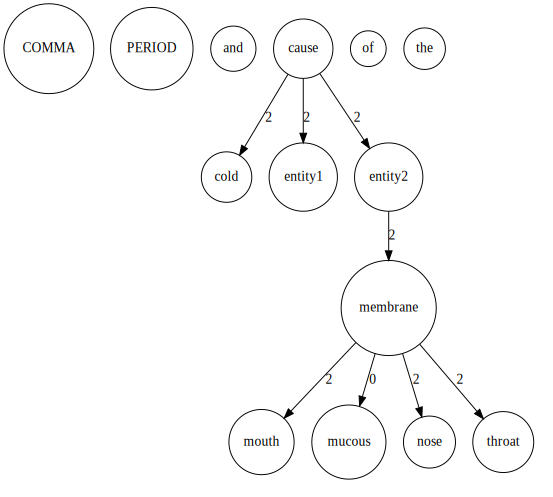

In [252]:
Source(to_dot(g))